In [1]:
import os.path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from pathlib import Path
from tqdm import tqdm
from time import perf_counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display


from keras.models import Sequential
from keras.layers import MaxPooling2D
from keras.layers import Conv2D
from keras.layers import Activation, Dropout, Flatten, Dense
import numpy as np
import os

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
# 드라이브 마운트

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import os
import zipfile

local_zip = '/content/drive/MyDrive/data/snack-data.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

In [8]:
# 경로 지정하기

# 기본 경로
base_dir = '/tmp'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# 훈련에 사용되는 포카칩 새우깡 이미지 경로
train_pocachip_dir = os.path.join(train_dir, 'train-pocachip')
train_shrimpcracker_dir = os.path.join(train_dir, 'train-shrimpcracker')
train_cola_dir = os.path.join(train_dir, 'train-cola')
train_sprite_dir = os.path.join(train_dir, 'train-sprite')
print(train_pocachip_dir)
print(train_shrimpcracker_dir)
print(train_cola_dir)
print(train_sprite_dir)

# 테스트에 사용되는 포카칩 새우깡 이미지 경로
validation_pocachip_dir = os.path.join(validation_dir, 'validation-pocachip')
validation_shrimpcracker_dir = os.path.join(validation_dir, 'validation-shrimpcracker')
validation_cola_dir = os.path.join(validation_dir, 'validation-cola')
validation_sprite_dir = os.path.join(validation_dir, 'validation-sprite')

print(validation_pocachip_dir)
print(validation_shrimpcracker_dir) 
print(validation_cola_dir) 
print(validation_sprite_dir) 

/tmp/train/train-pocachip
/tmp/train/train-shrimpcracker
/tmp/train/train-cola
/tmp/train/train-sprite
/tmp/validation/validation-pocachip
/tmp/validation/validation-shrimpcracker
/tmp/validation/validation-cola
/tmp/validation/validation-sprite


In [9]:
dir_ = Path('/tmp/train')
filepaths = list(dir_.glob(r'**/*.jpg'))
def proc_img(filepath):
    """
   		이미지데이터의 경로와 label데이터로 데이터프레임 만들기 
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # 경로와 라벨 concatenate
    df = pd.concat([filepath, labels], axis=1)

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)
    
    return df

df = proc_img(filepaths)
df.head(4)

,Filepath,Label
0,/tmp/train/train-shrimpcracker/shrimpcracker49...,train-shrimpcracker
1,/tmp/train/train-sprite/sprite18.jpg340111.jpg,train-sprite
2,/tmp/train/train-pocachip/pocachip0.jpg20111.jpg,train-pocachip
3,/tmp/train/train-cola/cola64.jpg340111.jpg,train-cola


In [10]:
print(f'Number of pictures: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}')

Number of pictures: 4428

Number of different labels: 4

Labels: ['train-shrimpcracker' 'train-sprite' 'train-pocachip' 'train-cola']


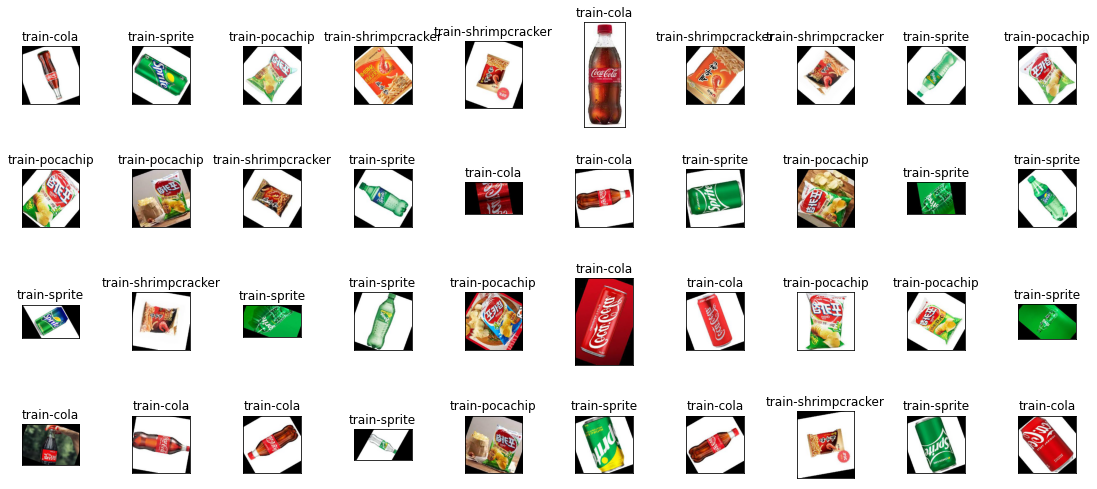

In [ ]:
# 데이터 확인
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

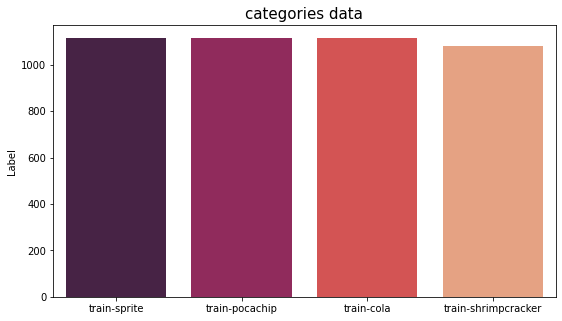

train-sprite           1116
train-pocachip         1116
train-cola             1116
train-shrimpcracker    1080
Name: Label, dtype: int64


In [11]:
vc = df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("categories data", fontsize = 15)
plt.show()
print(vc)

In [12]:
# Training/test split
# train_df,test_df = train_test_split(df.sample(frac=0.2), test_size=0.1,random_state=0) #모델링 시간이 오래걸리면 사용
train_df,test_df = train_test_split(df, test_size=0.1,random_state=0)
train_df.shape,test_df.shape

((3985, 2), (443, 2))

In [13]:
import numpy as np
import tensorflow as tf


from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split=0.2)

train_gen = train_datagen.flow_from_directory('/tmp/train',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',subset='training')
val_gen  = train_datagen.flow_from_directory('/tmp/train',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',subset='validation')

Found 3543 images belonging to 4 classes.
Found 885 images belonging to 4 classes.


In [ ]:
# Initialising the CNN
model = tf.keras.models.Sequential()

# Step 1 - Convolution  layer에서 32개의 filter 설정, filter size=3, 손실함수 relu
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[150, 150, 3], padding='same'))
# Step 2 - Pooling
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))


# Adding convolutional layer
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Adding convolutional layer
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
# Adding convolutional layer
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))


# Step 3 - Flattening
model.add(tf.keras.layers.Flatten())



# Step 4 - Full Connection
model.add(tf.keras.layers.Dense(units=512, activation='relu'))
# Step 5 - Output Layer
model.add(tf.keras.layers.Dense(units=4, activation='softmax'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 75, 75, 32)        9248      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 37, 37, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 35, 35, 64)        18496     
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 17, 17, 64)      

In [ ]:
# Compiling the CNN
model.compile(optimizer = 'adam', 
            loss = 'categorical_crossentropy', 
            metrics = ['accuracy'])


In [ ]:
history = model.fit(x = train_gen, validation_data = val_gen, epochs = 5)

Epoch 1/5
111/111 [==============================] - 116s 1s/step - loss: 0.4269 - accuracy: 0.8171 - val_loss: 0.2081 - val_accuracy: 0.9537
Epoch 2/5
111/111 [==============================] - 113s 1s/step - loss: 0.0299 - accuracy: 0.9929 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 3/5
111/111 [==============================] - 115s 1s/step - loss: 5.3262e-04 - accuracy: 1.0000 - val_loss: 0.0114 - val_accuracy: 0.9921
Epoch 4/5
111/111 [==============================] - 115s 1s/step - loss: 1.1684e-04 - accuracy: 1.0000 - val_loss: 0.0127 - val_accuracy: 0.9898
Epoch 5/5
111/111 [==============================] - 117s 1s/step - loss: 5.4978e-05 - accuracy: 1.0000 - val_loss: 0.0122 - val_accuracy: 0.9898


In [ ]:
train_gen.class_indices

{'train-cola': 0,
 'train-pocachip': 1,
 'train-shrimpcracker': 2,
 'train-sprite': 3}

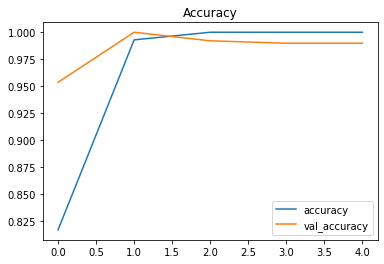

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

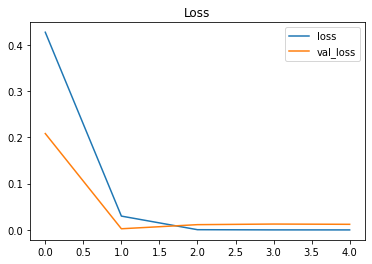

In [ ]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [ ]:
 # 테스트 이미지 분류uk
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input


uploaded=files.upload()  # PC에서 파일 업로드


class_dictionary = {'cola': 0,
                    'pocachip': 1,
                    'shrimpsnacker': 2,
                    'sprite': 3}


for fn in uploaded.keys():

  path='/content/' + fn
  img=image.load_img(path, target_size=(150, 150))

  x=image.img_to_array(img)
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])

  classes = model.predict(images, batch_size=10)

  df = pd.DataFrame({'pred':classes[0]})
  df = df.sort_values(by='pred', ascending=False, na_position='first')
  print((df.iloc[0]['pred'])* 100)

  for x in class_dictionary:
    if class_dictionary[x] == (df[df == df.iloc[0]].index[0]):
      print(x)
      break



Saving t-p3.jpg to t-p3.jpg
1/1 [==============================] - 0s 59ms/step
[[0.0000000e+00 1.0899738e-10 0.0000000e+00 1.0000000e+00]]


"\n df = pd.DataFrame({'pred':classes[0]})\n df = df.sort_values(by='pred', ascending=False, na_position='first')\n print((df.iloc[0]['pred'])* 100)\n\n for x in class_dictionary:\n   if class_dictionary[x] == (df[df == df.iloc[0]].index[0]):\n     print(x)\n     break\n"

In [ ]:
from keras.models import load_model

model.save('4-snack.h5')

from google.colab import files
files.download('4-snack.h5')  # from colab to browser download

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  import sys


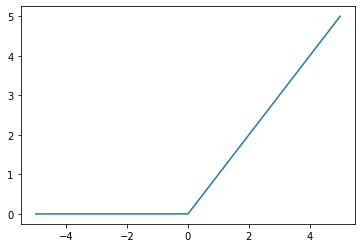

In [ ]:
#Relu 구현 20174068 김경환

import torch
import matplotlib.pyplot as plt

relu = torch.nn.ReLU()
x=torch.range(-5, 5, 0.1)
y=relu(x)

plt.plot(x.numpy(), y.numpy())
plt.show()